In [20]:
%load_ext autoreload
%autoreload 2

from montlake.atomgeom.features import get_features,get_D_feats_feats
from montlake.atomgeom.utils import get_atoms_4
from montlake.simulations.rigidethanol import get_rigid_ethanol_data
from montlake.utils.utils import get_234_indices, get_atoms3_full, get_atoms4_full, data_stream_custom_range, get_cosines
from montlake.geometry.geometry import get_geom, get_wlpca_tangent_sel, get_rm_tangent_sel
from montlake.gradients.estimate import get_grads_pullback
from montlake.statistics.normalization import normalize_L212
from montlake.optimization.gradientgrouplasso import get_sr_lambda_parallel
from montlake.optimization.utils import get_selected_function_ids,get_selected_functions_lm2
from montlake.utils.replicates import Replicate, get_supports_brute
from montlake.plotting.manifolds import plot_manifold_2d,plot_manifold_featurespace
from montlake.plotting.flasso import plot_reg_path_ax_lambdasearch_customcolors_norm, plot_watch_custom
from megaman.embedding import SpectralEmbedding
from montlake.statistics.supportrecovery import get_min_min, get_mu_full_ind, get_kappa_s,get_gamma_max

import pandas as pd
import dill as pickle
import os
import sys
import numpy as np
import itertools
from itertools import permutations,combinations
from sklearn.decomposition import TruncatedSVD
import pathos
from pathos.multiprocessing import ProcessingPool as Pool

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
infile = '/Users/samsonkoelle/thesis_data/processed_data/toluene/toluene_diagram_112321results_mflasso'
with open(infile,'rb') as inp:
    results = pickle.load(inp, pickle.HIGHEST_PROTOCOL)

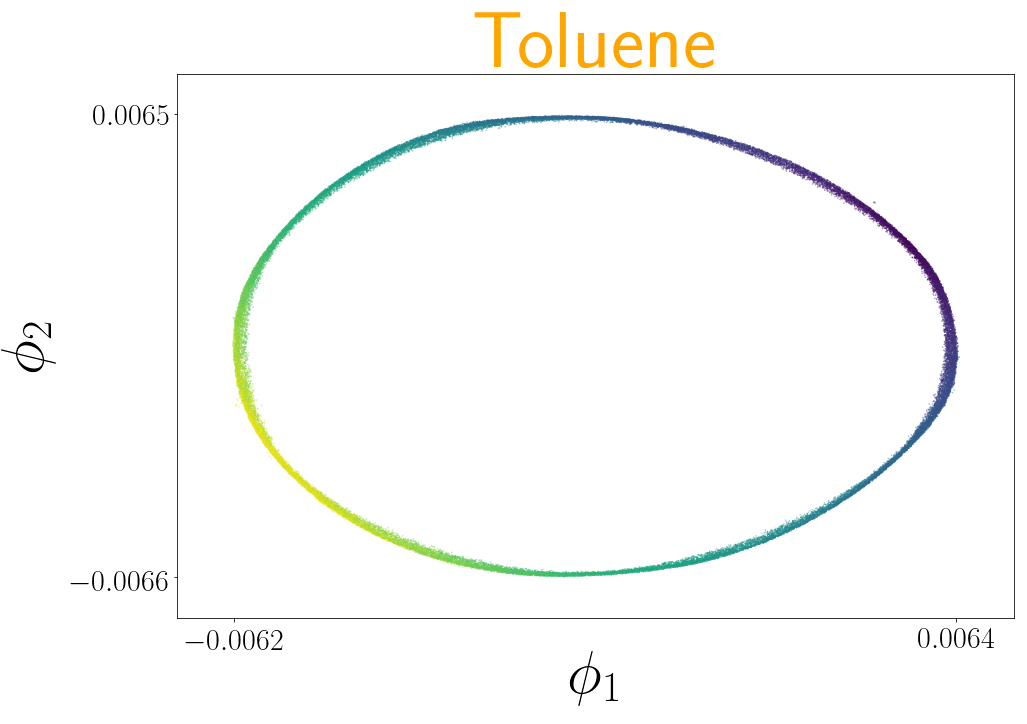

In [3]:
alpha = 1
s = 1
title = 'Toluene'
n = 50000
colors = np.vstack([np.hstack(results['selected_function_values'][i]) for i in range(n)])
c= colors[:,0]
embed = results['embed']
plot_manifold_2d(embed, s, alpha, c, title)#from montlake.plotting.manifold import plot_manifold

0
1
2
3
4
5


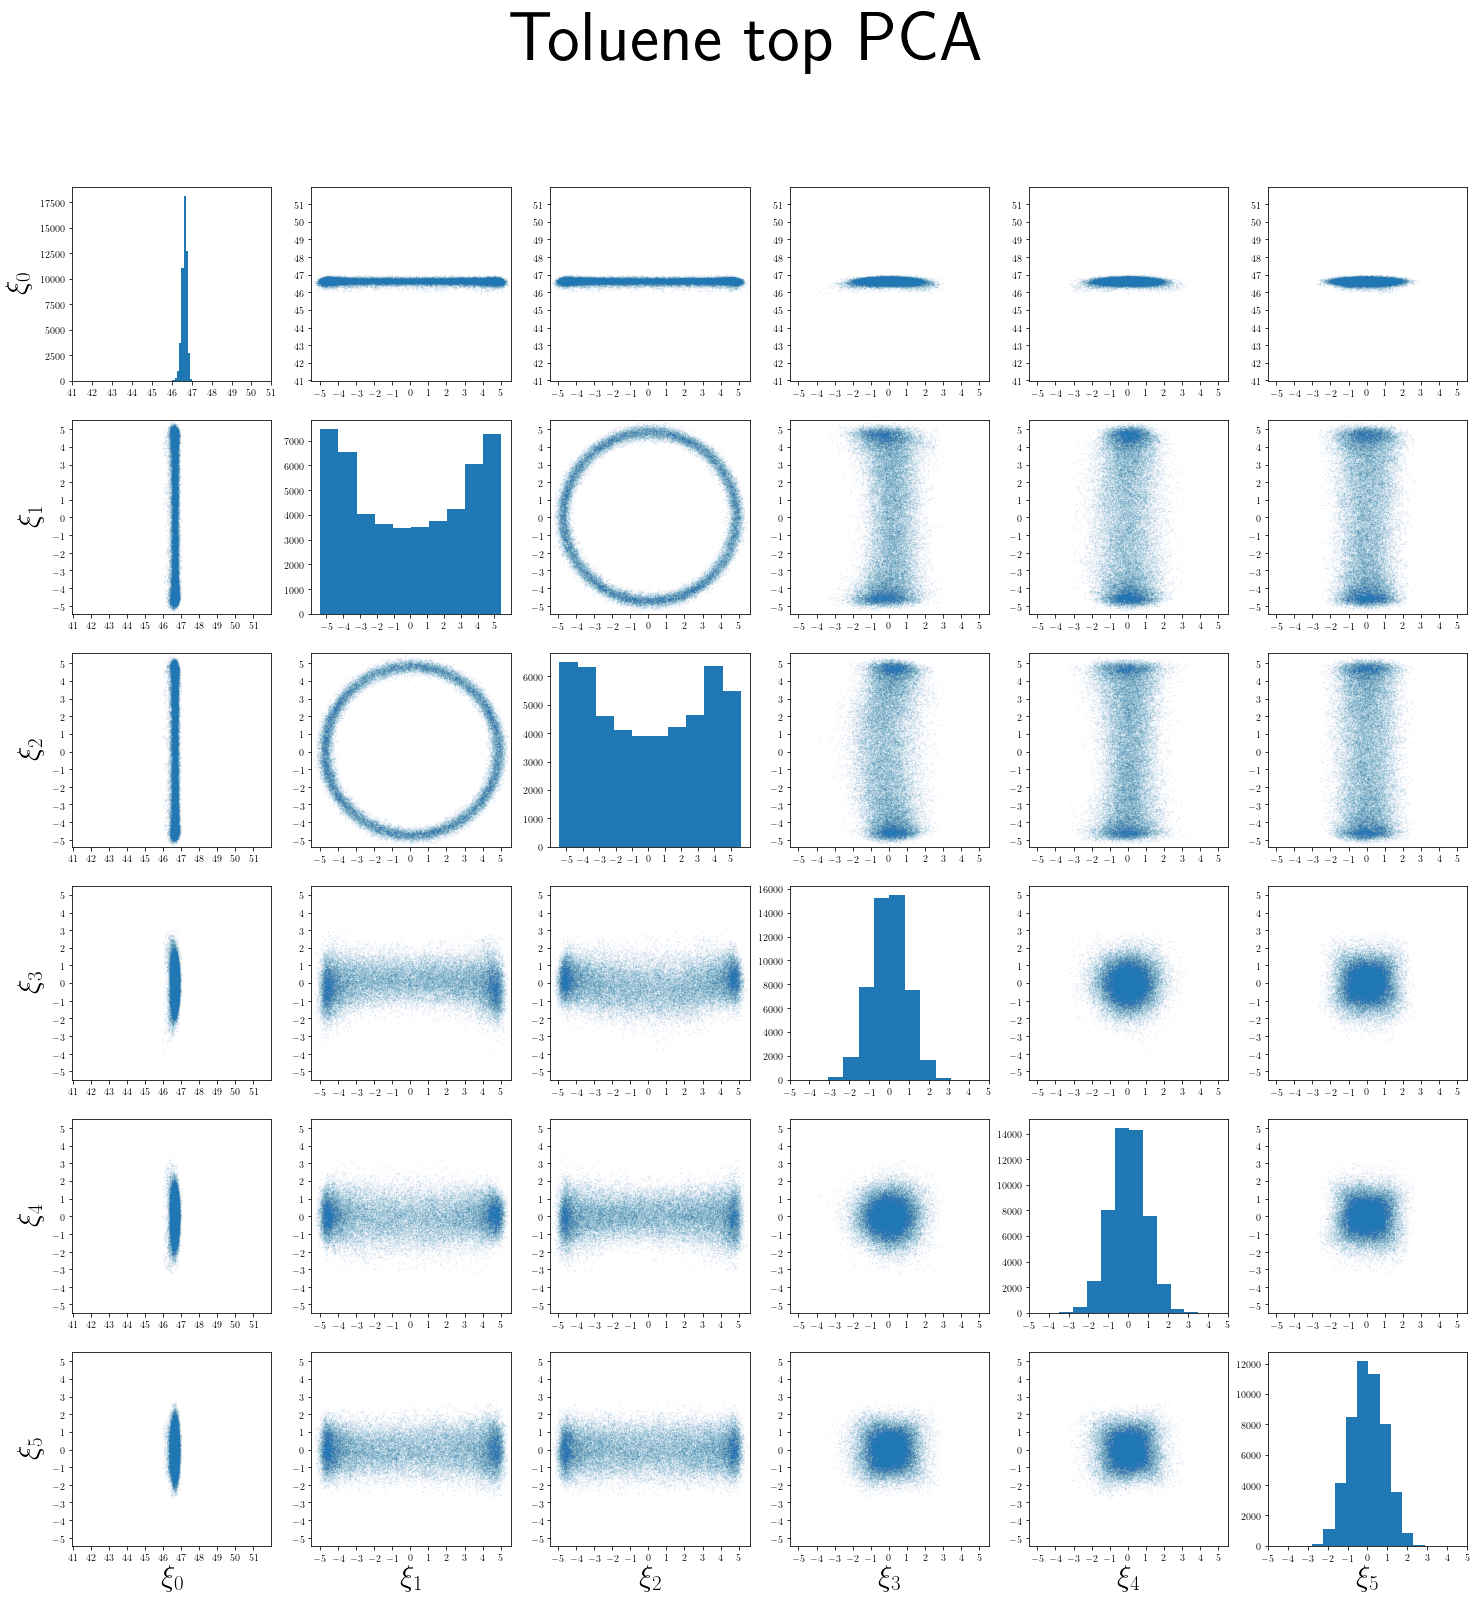

In [4]:
#i = 0
data = results['data']
title = 'Toluene top PCA'
ncord = 6
plot_manifold_featurespace(data,title,ncord)

AttributeError: 'Replicate' object has no attribute 'cs_reorder'

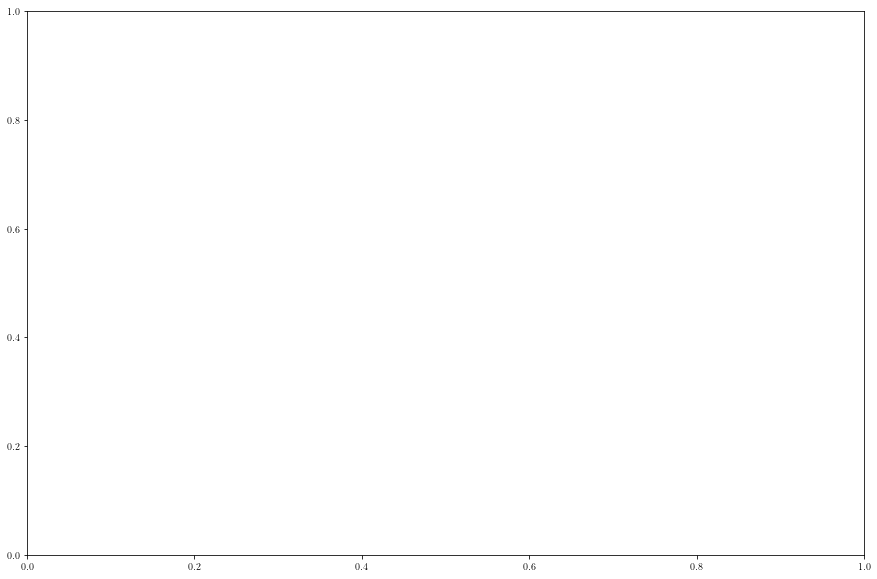

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes_all = plt.subplots(figsize=(15, 10))

colors = np.hstack([np.repeat('orange',6), np.repeat('blue',24)])
plot_reg_path_ax_lambdasearch_customcolors_norm(axes_all, results['replicates_small'][0].cs_reorder, results['replicates_small'][0].xaxis_reorder / results['replicates_small'][0].xaxis_reorder.max() , fig,colors)#axes_all[0].imshow(asdf)
axes_all.set_title('Regularization path (single replicate)', fontsize = 40)
axes_all.set_ylabel(r'$||\beta_j||$', fontsize = 40)
axes_all.set_xticklabels([])
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/tol30_replicate')

In [9]:
results.keys()

dict_keys(['supports_brute', 'data', 'supports_lasso', 'geom', 'selected_functions_unique_twostage', 'selected_functions_unique', 'selected_function_values_brute', 'replicates_small', 'embed', 'selected_function_values'])

In [ ]:
vars(results['replicates_small'][0]).keys()

1.0 0.0
0.9781476007338057 0.20791169081775931
0.9135454576426009 0.40673664307580015
0.8090169943749475 0.5877852522924731
0.6691306063588583 0.7431448254773941
0.5000000000000001 0.8660254037844386
0.30901699437494745 0.9510565162951535
0.10452846326765367 0.9945218953682733
-0.10452846326765333 0.9945218953682734
-0.30901699437494734 0.9510565162951536
-0.4999999999999998 0.8660254037844388
-0.6691306063588579 0.7431448254773945
-0.8090169943749473 0.5877852522924732
-0.9135454576426008 0.40673664307580043
-0.9781476007338056 0.20791169081775973
-1.0 1.2246467991473532e-16
-0.9781476007338057 -0.20791169081775907
-0.9135454576426011 -0.4067366430757998
-0.8090169943749475 -0.587785252292473
-0.6691306063588585 -0.743144825477394
-0.5000000000000004 -0.8660254037844384
-0.30901699437494756 -0.9510565162951535
-0.10452846326765423 -0.9945218953682733
0.104528463267653 -0.9945218953682734
0.30901699437494723 -0.9510565162951536
0.4999999999999993 -0.866025403784439
0.6691306063588578 -

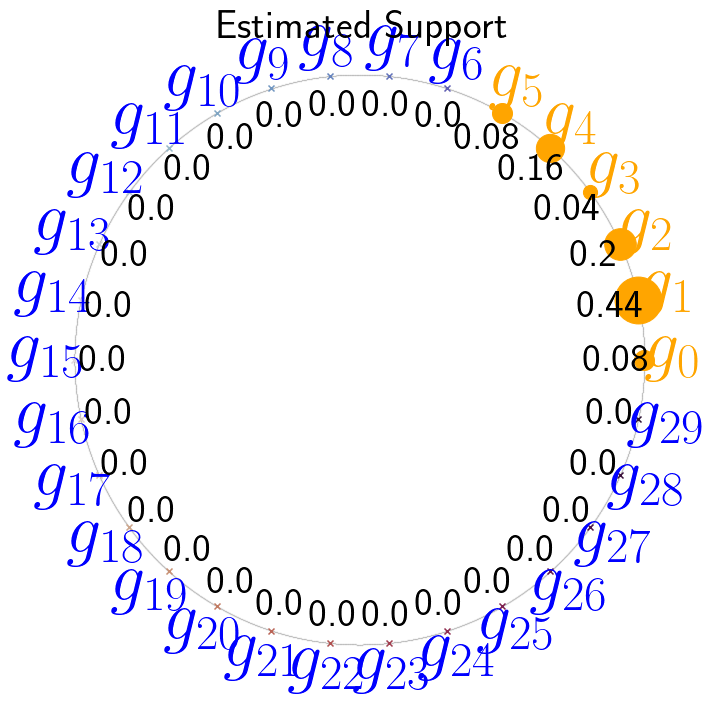

In [12]:
fig, axes_all = plt.subplots(figsize=(15, 10))
nreps = 25
plot_watch_custom(results['supports_brute'], 30, axes_all,colors, nreps)
axes_all.set_title('Estimated Support', fontsize = 40)
plt.tight_layout()
#plt.savefig('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/Figures/figure_for_jmlr/tol30_support')

In [21]:
nreps = 25
nsel = 100
n = nsel
min_mins = np.zeros(nreps, dtype = np.float64)
mus = np.zeros(nreps, dtype = np.float64)
kappas = np.zeros(nreps, dtype = np.float64)
gamma_maxs = np.zeros(nreps, dtype = np.float64)
for r in range(nreps):
    print(r)
    inds = np.asarray([1])#sel_tol[r]
    dg_M = results['replicates_small'][r].dg_M
    min_mins[r]  = get_min_min(dg_M[:,:,inds]*n)
    mus[r] = get_mu_full_ind(np.swapaxes(dg_M,1,2)*n, inds)
    kappas[r] = get_kappa_s(results['replicates_small'][r].dg_M[:,:,inds[0]:(inds[0]+1)]*n)
    gamma_maxs[r] = get_gamma_max(dg_M[:,:,inds]*np.sqrt(n ) )
    
columns = np.asarray([r'$\bar \mu$', r'$\sigma_\mu$',
                     r'$\bar {\kappa_S}$', r'$\sigma_{\kappa_S}$',
                     r'$\bar {\gamma_{\text{max}}}$', r'$\sigma_{\gamma_{\text{max}}}$',
                     r'$\bar {\min_{i = 1}^{n} \min_{j \in S } ||x_{ij}|| }$', r'$\sigma_\mu$'])

df_tol_apriori = pd.DataFrame(np.asarray([np.mean(mus), np.sqrt(np.var(mus)), 
                    np.mean(kappas), np.sqrt(np.var(kappas)),
                    np.mean(gamma_maxs),np.sqrt(np.var(gamma_maxs)),
                    np.mean(min_mins),np.sqrt(np.var(min_mins))]).transpose(), index = columns).transpose()

df_tol_apriori.to_csv('/Users/samsonkoelle/Downloads/manigrad-100818/mani-samk-gradients/untracked_data/embeddings/toldiagramparam.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
